### Questions

**How to reduce the dimension of data?**
  - 20 columns is not bad but could be less
  - 12684 rows is much -> resampling?
  
[Taras]: I I think we should try as it is first, <100K samples should be very managable by all the models we covered. Resampling is probably unnecessary unless our Y-variable is imbalanced, which it doesn't seem to be based on the mean value close to 0.5.
- For the number of columns I'm less sure, but once again I'm in favour of quick iteration. So I'd suggest we try the currently proposed encoding scheme without removing any columns first and check the results.
- Then we can try things like searching for the best combination of columns via different algorithms we covered (e.g. permutation importance), if there's some overfitting or if the accuracy is perfect.

**How to encode categorical data?**
  - Data without order -> One-Hot (ex: 'weather') or Binary (ex: 'gender')  
  - Data with order -> 0,1,2 encoding (ex: 'time')
  - [Taras: agreed, I wrote my thoughts here more verbosely in the end of "# Categorical Data Analysis" before I saw this :D]

**How to handle NaNs**:
- [Taras]: we can try the current approach with discarding all the columns with NaNs, but I think if we just remove the `car` column, our percentage of NaN rows will drop drastically. And the remaining NaNs are ~5% rows, so if we remove those we still preserve some potentially valuable info about the driver's preferences.

**Do we need encoding?**
  - For Decision Tree -> No [Taras: I think yes for scikit-learn, it works only with numerical columns]
  - For Network -> Yes

**Doing PCA?**
  - Using PCA for categorical and binary data does not have sense
  - [Taras]: agree, we have too few numerical columns

### To do

- Checking clasterization quality using silhouette?
  - I can be used fo encoding problem -> the problem might be for data with no natural order, using silhoutte we can choose the encoding which gives silhoutte value, to optimize Decision Tree and Network working

- Decision Tree

- Network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Getting the dictonary of categorical values (as a list) for each column for example: 'gender': ['Female', 'Male']
def GetCat(CatCol, data):
    CatColDict = {}
    for k in CatCol:
        Cat = []
        for d in data[k]:
            if d not in Cat:
                Cat.append(d)
        CatColDict[k] = Cat
    return CatColDict

# Encoding the categorical values for example: 'gender': ['Female', 'Male'] -> 'gender': {'Female': 0, 'Male': 1}
def CatEncoding(CatColDict):
    CatColEnc = {}
    for k in CatColDict:
        i = 0
        Enc = {}
        for c in CatColDict[k]:
            Enc[c] = i
            i += 1
        CatColEnc[k] = Enc
    return CatColEnc

# Change the data categorical columns with given encoding
def EncDataSet(Col, CatColEnc, data):
    NewData = pd.DataFrame()
    for k in Col:
        if k not in CatColEnc:
            NewData[k] = data[k]
        else:
            NewCol = []
            for d in data[k]:
                NewCol.append(CatColEnc[k][d])
            NewData[k] = NewCol
    return NewData
        

## Dataset loading & inspection

In [2]:
# Getting data

data = pd.read_csv('in-vehicle-coupon-recommendation.csv')
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [4]:
# Check numerical/binary columns
data.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Check categorical columns
for col in data.columns:
    if data[col].dtype == 'object' or data[col].dtype.name == 'category':
        print(f"\n--- {col} ---")
        counts = data[col].value_counts(dropna=False)
        proportions = data[col].value_counts(dropna=False, normalize=True)
        combined = pd.concat([counts, proportions], axis=1)
        combined.columns = ['count', 'proportion']
        print(combined)


--- destination ---
                 count  proportion
destination                       
No Urgent Place   6283    0.495348
Home              3237    0.255203
Work              3164    0.249448

--- passanger ---
           count  proportion
passanger                   
Alone       7305    0.575922
Friend(s)   3298    0.260013
Partner     1075    0.084752
Kid(s)      1006    0.079313

--- weather ---
         count  proportion
weather                   
Sunny    10069    0.793835
Snowy     1405    0.110769
Rainy     1210    0.095396

--- time ---
      count  proportion
time                   
6PM    3230    0.254652
7AM    3164    0.249448
10AM   2275    0.179360
2PM    2009    0.158389
10PM   2006    0.158152

--- coupon ---
                       count  proportion
coupon                                  
Coffee House            3996    0.315043
Restaurant(<20)         2786    0.219647
Carry out & Take away   2393    0.188663
Bar                     2017    0.159019
Restaurant(20-5

### Notes from the call

`--- destination ---
                 count  proportion
destination                       
No Urgent Place   6283    0.495348
Home              3237    0.255203
Work              3164    0.249448
`

- No Urgent Place -> (1, 0, 0)
- Home ->            (0, 1, 0)
- Work ->            (0, 0, 1)

Maybe make a config like this?

In [ ]:
config = {
    'destination': {"isOnehot": True} # True
    'education': {"isOnehot": True},
    # ...
}

# NaN Analysis

In [10]:
# The number of rows with NaN values
NanRow = data[data.isna().any(axis=1)]
print(f'Number of rows with Nan values: {len(NanRow)}')
print(f'In %:  {round(len(NanRow)/len(data)*100, 1)}')

Number of rows with Nan values: 12576
In %:  99.1


In [11]:
# The number of rows with NaN values

NanCol = data.columns[data.isna().any()].tolist()
print(f'Number of columns with Nan values: {len(NanCol)}')
print(f'In %:  {round(len(NanCol)/len(data.columns)*100, 1)}')
print('All such columns are categorical type columns')

Number of columns with Nan values: 6
In %:  23.1
All such columns are categorical type columns


Let's also check which specific columns have NaNs and how many

In [12]:
# Check for NaNs per column
nan_counts = data.isna().sum()

# Filter only the columns with at least one NaN
nan_counts = nan_counts[nan_counts > 0]

# Optionally, also print the proportion of NaNs
nan_info = pd.DataFrame({
    'missing_count': nan_counts,
    'missing_fraction': nan_counts / len(data)
})

print(nan_info)

                      missing_count  missing_fraction
car                           12576          0.991485
Bar                             107          0.008436
CoffeeHouse                     217          0.017108
CarryAway                       151          0.011905
RestaurantLessThan20            130          0.010249
Restaurant20To50                189          0.014901


Since the prencentage of Nan rows is much bigger then the prencentage of Nan columns, I propose to delete these 6 columns.
- [Taras] we can do that, but I think if we just remove the `car` column, our percentage of NaN rows will drop drastically. And the remaining NaNs are ~5% rows, so if we remove those we still preserve some potentially valuable info about the driver's preferences

In [13]:
# Delete Nan columns

data = data.drop(NanCol, axis = 1)
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,1,1,1,0,1,0


# Categorical Data Analysis

In [14]:
# Getting columns with categorical values

CatCol = data.select_dtypes(include=['object']).columns.tolist()
CatCol

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income']

In [15]:
# Getting the values of each categorical column

CatColDict = GetCat(CatCol, data)
CatColDict

{'destination': ['No Urgent Place', 'Home', 'Work'],
 'passanger': ['Alone', 'Friend(s)', 'Kid(s)', 'Partner'],
 'weather': ['Sunny', 'Rainy', 'Snowy'],
 'time': ['2PM', '10AM', '6PM', '7AM', '10PM'],
 'coupon': ['Restaurant(<20)',
  'Coffee House',
  'Carry out & Take away',
  'Bar',
  'Restaurant(20-50)'],
 'expiration': ['1d', '2h'],
 'gender': ['Female', 'Male'],
 'age': ['21', '46', '26', '31', '41', '50plus', '36', 'below21'],
 'maritalStatus': ['Unmarried partner',
  'Single',
  'Married partner',
  'Divorced',
  'Widowed'],
 'education': ['Some college - no degree',
  'Bachelors degree',
  'Associates degree',
  'High School Graduate',
  'Graduate degree (Masters or Doctorate)',
  'Some High School'],
 'occupation': ['Unemployed',
  'Architecture & Engineering',
  'Student',
  'Education&Training&Library',
  'Healthcare Support',
  'Healthcare Practitioners & Technical',
  'Sales & Related',
  'Management',
  'Arts Design Entertainment Sports & Media',
  'Computer & Mathematica

In [16]:
# Encoding the categorical values

CatColEnc = CatEncoding(CatColDict)
CatColEnc

{'destination': {'No Urgent Place': 0, 'Home': 1, 'Work': 2},
 'passanger': {'Alone': 0, 'Friend(s)': 1, 'Kid(s)': 2, 'Partner': 3},
 'weather': {'Sunny': 0, 'Rainy': 1, 'Snowy': 2},
 'time': {'2PM': 0, '10AM': 1, '6PM': 2, '7AM': 3, '10PM': 4},
 'coupon': {'Restaurant(<20)': 0,
  'Coffee House': 1,
  'Carry out & Take away': 2,
  'Bar': 3,
  'Restaurant(20-50)': 4},
 'expiration': {'1d': 0, '2h': 1},
 'gender': {'Female': 0, 'Male': 1},
 'age': {'21': 0,
  '46': 1,
  '26': 2,
  '31': 3,
  '41': 4,
  '50plus': 5,
  '36': 6,
  'below21': 7},
 'maritalStatus': {'Unmarried partner': 0,
  'Single': 1,
  'Married partner': 2,
  'Divorced': 3,
  'Widowed': 4},
 'education': {'Some college - no degree': 0,
  'Bachelors degree': 1,
  'Associates degree': 2,
  'High School Graduate': 3,
  'Graduate degree (Masters or Doctorate)': 4,
  'Some High School': 5},
 'occupation': {'Unemployed': 0,
  'Architecture & Engineering': 1,
  'Student': 2,
  'Education&Training&Library': 3,
  'Healthcare Suppo

In [17]:
# Changing the catagorical values to numerical values acording to given encoding

data = EncDataSet(data.columns.tolist(), CatColEnc, data)
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,0,55,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1
1,0,1,0,80,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,1,0,80,1,2,1,0,0,0,1,0,0,0,1,1,0,0,1,1
3,0,1,0,80,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0
4,0,1,0,80,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1,3,1,55,2,2,0,1,2,1,0,1,6,3,1,0,0,1,0,1
12680,2,0,1,55,3,2,0,1,2,1,0,1,6,3,1,0,0,0,1,1
12681,2,0,2,30,3,1,0,1,2,1,0,1,6,3,1,0,0,1,0,0
12682,2,0,2,30,3,3,0,1,2,1,0,1,6,3,1,1,1,0,1,0


[Taras] I think we need to think about this a bit more. Typically (also discussed in our lectures), categorical vars are treated differently depending on whether they are ordered (e.g. `'time': {'2PM': 0, '10AM': 1, '6PM': 2, '7AM': 3, '10PM': 4}`) or unordered (e.g. `'maritalStatus': {'Unmarried partner': 0, 'Single': 1, 'Married partner': 2, 'Divorced': 3, 'Widowed': 4}`). If we make sure the order is correct, the current approach seems fine for the ordered ones.

But for unordered ones, I think using integer encoding doesn’t make much sense. For example, if we assign these values to the destination column: `'destination': {'No Urgent Place': 0, 'Home': 1, 'Work': 2`}, then the model has to learn that these numbers don’t really mean anything numeric, but rather our encoded categories (and then, what these categories correlate with). [This might be less of an issue for models like decision trees (which are good at learning piecewise constant rules), but for models like SVD or anything linear, this kind of encoding can lead to some serious overfitting]

It’s generally easier for the model if we use binary encoding (e.g. `'IsSingle' == 1` if `maritalStatus = 'Single'`, `'isMale' == 1` if `Gender = 'Male'` etc). This will create more columns (because each unordered columns with `N` values will be mapped to `N-1` distinct binary columns), but we don't have that many unordered columns, so I don't think this would be an issue.

# PCA Analysis ? Maybe no

In [18]:
# # Scaling the data before PCA

# scaler = StandardScaler()
# scaler.fit(data)
# data = scaler.transform(data)

In [19]:
# Extracting the decision column Y from data and removing it from data

DecCol = data['Y']
dataAtr = data.drop('Y', axis = 1)

Explaind variance ratio: 0.86
From Scree plot we see that the optimal PCs order is 3


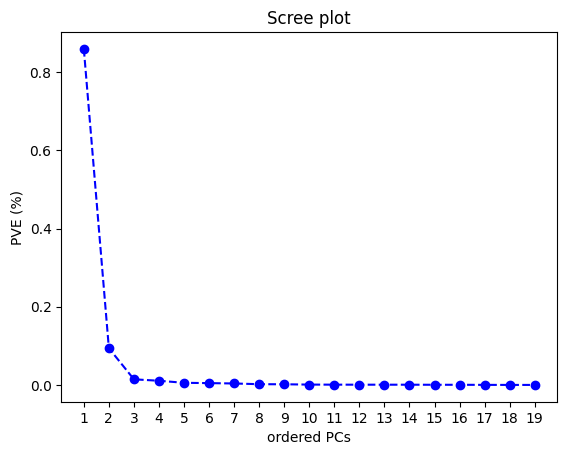

In [20]:
# Serching for optimal PC's order using Scree plot

pca_check = PCA(n_components = 19)
pca_coordinates = pca_check.fit_transform(dataAtr)
plt.plot(pca_check.explained_variance_ratio_, linestyle='--', marker='o', color='b')
plt.title('Scree plot')
plt.xlabel('ordered PCs')
plt.xticks([i for i in range(19)], [i+1 for i in range(19)])
plt.ylabel('PVE (%)')
# print(pca_model.explained_variance_ratio_)
print(f'Explaind variance ratio: {round(np.sum(pca_check.explained_variance_ratio_[:1]),2)}')
print('From Scree plot we see that the optimal PCs order is 3')

In [21]:
# Changing data usig PCA of order 3

pca_model = PCA(n_components=3)
data = pd.DataFrame(pca_model.fit_transform(dataAtr), columns = ['z1', 'z2', 'z3'])
data['Y'] = DecCol
# print(f'Explaind variance ratio: {round(np.sum(pca_model.explained_variance_ratio_[:1]),2)}')

In [22]:
data

,z1,z2,z3,Y
0,-8.182413,-7.662865,-4.688865,1
1,16.792724,-7.507503,-4.587928,0
2,16.781907,-7.505178,-4.579463,1
3,16.801945,-7.505384,-4.590494,0
4,16.798726,-7.505481,-4.589638,0
...,...,...,...,...
12679,-8.289780,-1.727689,-1.087485,1
12680,-8.321390,-1.735068,-1.095317,1
12681,-33.321902,-1.890758,-1.188298,0
12682,-33.347319,-1.885506,-1.174923,0
